In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(style="ticks", font_scale=1.2)

In [2]:
# Define output IVs (from the final layer).
OUTPUT_IV_MAP = {
    "entropy_first_token": "output_entropy",
    "reciprocal_rank_correct": "output_rank_correct",
    "first_logprob_correct": "output_logprob_correct",
    "first_logprob_diff": "output_logprobdiff"
}
OLD_OUTPUT_IVS = ["entropy_first_token", "reciprocal_rank_correct", "first_logprob_correct", "first_logprob_diff"]
OUTPUT_IVS = [OUTPUT_IV_MAP[i] for i in OLD_OUTPUT_IVS]
print(f"OUTPUT measures ({len(OUTPUT_IVS)}):", OUTPUT_IVS)

# Define process IVs based purely on probabilities.
PROB_IVS = []
for output_iv in OUTPUT_IVS:
    # Get base name of metric (e.g., "entropy")
    iv = output_iv.replace("output_", "")
    # Add AUC measure(s).
    if iv == "logprobdiff":
        PROB_IVS.append(f"auc_{iv}_pos")
        PROB_IVS.append(f"auc_{iv}_neg")
    else:
        PROB_IVS.append(f"auc_{iv}")
    # Add biggest change measure.
    PROB_IVS.append(f"layer_biggest_change_{iv}")
# Define **control** process IVs.
CONTROL_PROB_IVS = ["control_" + iv for iv in PROB_IVS]

# Define process IVS based on scalar projections.
SCALAR_PROJ_IVS = [
    "auc_boost_pos",
    "auc_boost_neg",
    "layer_argmax_boost"
]

PROCESS_IVS = PROB_IVS + SCALAR_PROJ_IVS + CONTROL_PROB_IVS
print(f"PROCESS measures ({len(PROCESS_IVS)}):", PROCESS_IVS)

TASK_DVS = {
    "capitals-recall": [
        "response_correct_strict", 
        "response_correct_gpt4", 
        "rt", 
        "time_stroke_after_last_empty_trial", 
        "n_keystrokes_len_norm",
        "n_backspace"
    ],
    "capitals-recognition": ["response_correct", "rt"],
    "animals": ["response_correct", "RT", "MAD", "AUC", "xpos_flips", "acc_max_time"],
    "syllogism": ["response_correct", "rt"],
    "vision": ["response_correct", "rt"]
}
DV_MAP = {
    "response_correct_strict": "Accuracy (strict)",
    "response_correct_gpt4": "Accuracy (lenient)",
    "rt": "Response time",
    "RT": "Response time",
    "n_keystrokes_len_norm": "# Presses / len(final answer)",
    "n_backspace": "# Backspace presses",
    "time_stroke_after_last_empty_trial": "Time of first press after last empty",
    "response_correct": "Accuracy",
    "MAD": "MAD of trajectory",
    "AUC": "AUC of trajectory",
    "xpos_flips": "X-position flips",
    "acc_max_time": "Time of max acceleration"
}

def get_sig_code(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    elif p < 0.1:
        return "."
    else:
        return ""
    
def get_pretty_metric(m):
    metric_map = {
        "output_entropy": "Final-layer Entropy",
        "output_rank_correct": "Final-layer RRank",
        "output_logprob_correct": "Final-layer Logprob",
        "output_logprobdiff": "Final-layer $\Delta$Logprob",
        "auc_entropy": "Entropy AUC",
        "auc_rank_correct": "RRank AUC",
        "auc_logprob_correct": "Logprob AUC",
        "auc_logprobdiff_pos": "$\Delta$Logprob AUC+",
        "auc_logprobdiff_neg": "$\Delta$Logprob AUC-",
        "auc_boost_pos": "Boost AUC+",
        "auc_boost_neg": "Boost AUC-",
        "layer_biggest_change_entropy": "Entropy Layer",
        "layer_biggest_change_rank_correct": "RRank Layer",
        "layer_biggest_change_logprob_correct": "Logprob Layer",
        "layer_biggest_change_logprobdiff": "$\Delta$Logprob Layer",
        "layer_argmax_boost": "Boost Layer"
    }
    if m in metric_map:
        return metric_map[m]
    elif m.startswith("control") and m.replace("control_", "") in metric_map:
        return metric_map[m.replace("control_", "")] + " (Control)"
    else:
        return m
    
def get_metric_group(iv):
    if "entropy" in iv:
        return "Uncertainty"
    elif "rank" in iv or "logprob_correct" in iv:
        return "Confidence"
    elif "logprobdiff" in iv:
        return "Relative confidence"
    elif "boost" in iv:
        return "Boosting"
    else:
        return iv
METRIC_GROUP_PAL = {
    "Uncertainty": "#FF7676FF",
    "Confidence": "#F9D662FF",
    "Relative confidence": "#7CAB7DFF",
    "Boosting": "#75B7D1FF"
}

OUTPUT measures (4): ['output_entropy', 'output_rank_correct', 'output_logprob_correct', 'output_logprobdiff']
PROCESS measures (21): ['auc_entropy', 'layer_biggest_change_entropy', 'auc_rank_correct', 'layer_biggest_change_rank_correct', 'auc_logprob_correct', 'layer_biggest_change_logprob_correct', 'auc_logprobdiff_pos', 'auc_logprobdiff_neg', 'layer_biggest_change_logprobdiff', 'auc_boost_pos', 'auc_boost_neg', 'layer_argmax_boost', 'control_auc_entropy', 'control_layer_biggest_change_entropy', 'control_auc_rank_correct', 'control_layer_biggest_change_rank_correct', 'control_auc_logprob_correct', 'control_layer_biggest_change_logprob_correct', 'control_auc_logprobdiff_pos', 'control_auc_logprobdiff_neg', 'control_layer_biggest_change_logprobdiff']


In [3]:
def read_data(task, model="Llama-2-7b-hf"):
    df = pd.read_csv(f"../../data/human_model_combined/{task}_{model}.csv")
    return df

# Heatmaps

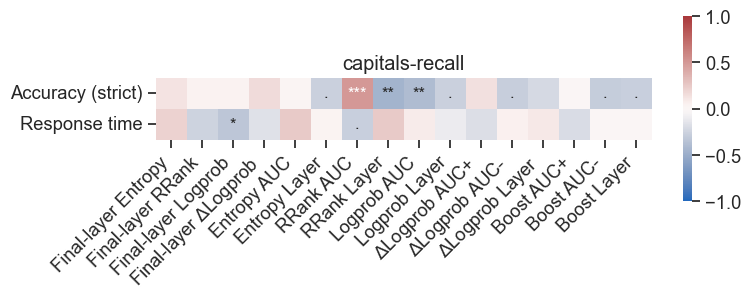

/Users/jenniferhu/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/jenniferhu/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


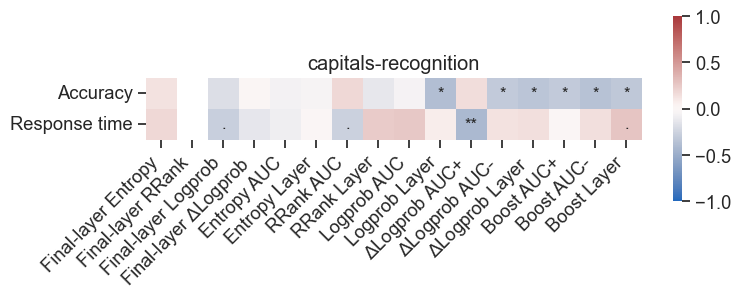

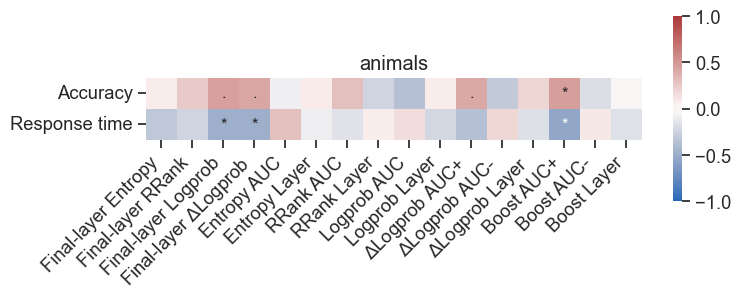

/Users/jenniferhu/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/jenniferhu/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


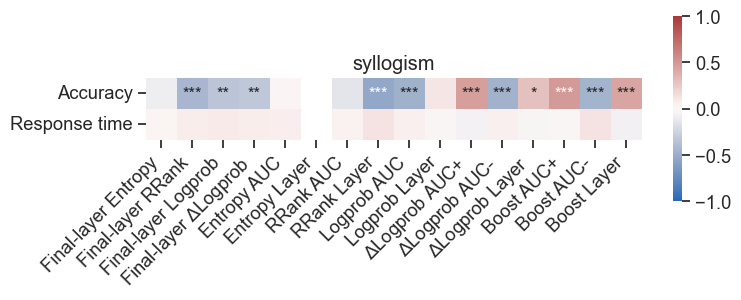

<Figure size 640x480 with 0 Axes>

In [4]:
def plot_corrs(df, dvs, ivs, grouping=["entity"]):
    corrs = np.zeros((len(dvs), len(ivs)))
    annot = []
    for i, dv in enumerate(dvs):
        row_annot = []
        for j, iv in enumerate(ivs):
            human_means = df.groupby(grouping)[dv].mean().to_frame()
            model_means = df.groupby(grouping)[iv].mean().to_frame()
            item_means = human_means.join(model_means, on=grouping)
            r, p = stats.pearsonr(item_means[iv], item_means[dv])
            corrs[i][j] = r
            row_annot.append(get_sig_code(p))
        annot.append(row_annot)
    ax = sns.heatmap(
        data=corrs,
        square=True,
        vmin=-1,
        vmax=1,
        cmap="vlag",
        annot=annot,
        fmt="",
        annot_kws={"size": "small"},
        cbar_kws={"shrink": 0.6}
    )
    ax.set_yticklabels([DV_MAP[dv] for dv in dvs], rotation=0)
    ax.set_xticks(
        [i+0.5 for i in range(len(ivs))], 
        [get_pretty_metric(iv) for iv in ivs], 
        rotation=45,
        ha="right"
    )
    plt.gcf().set_size_inches(8,4)
    return ax
    
groupings = {
    "capitals-recall": ["entity"],
    "capitals-recognition": ["entity"],
    "animals": ["exemplar"],
    "syllogism": ["unique_id"]
}
for task in ["capitals-recall", "capitals-recognition", "animals", "syllogism"]:
    df = read_data(task, model="Llama-2-7b-hf")
    if task == "capitals-recall":
        dv = "response_correct_strict"
    else:
        dv = "response_correct"
    dvs = [dv, "rt" if task != "animals" else "RT"]
    ivs = [iv for iv in OUTPUT_IVS + PROCESS_IVS if iv not in CONTROL_PROB_IVS]
    ax = plot_corrs(df, dvs, ivs, grouping=groupings[task])
    ax.set_title(task)
    plt.show()
    plt.clf()

# Scatterplots

In [5]:
def plot_means(df, dv, iv, grouping=["entity"], annot=False):
    human_means = df.groupby(grouping)[dv].mean().to_frame()
    model_means = df.groupby(grouping)[iv].mean().to_frame()
    item_means = human_means.join(model_means, on=grouping)
    ax = sns.regplot(
        data=item_means,
        x=iv,
        y=dv,
        color=METRIC_GROUP_PAL[get_metric_group(iv)]
    )
    r, p = stats.pearsonr(item_means[iv], item_means[dv])
    ax.text(0.03, 0.97, f"r = {r:.2g}, p = {p:.2g}", size="small", transform=ax.transAxes)
    ax.set_ylabel(DV_MAP[dv])
    ax.set_xlabel(get_pretty_metric(iv))
    if annot:
        for i, row in item_means.iterrows():
            ax.text(row[iv], row[dv], i, size="xx-small")
        
    plt.gcf().set_size_inches(4,4)
    sns.despine()

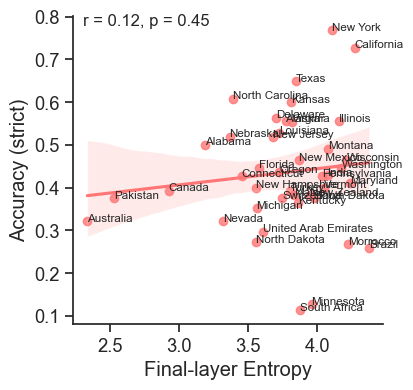

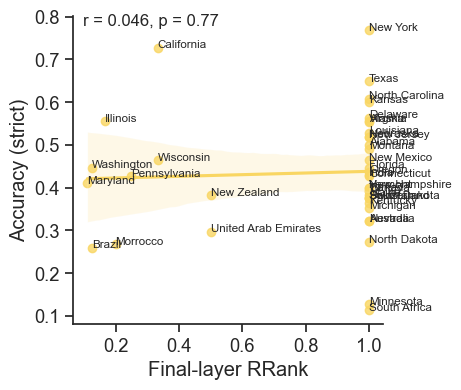

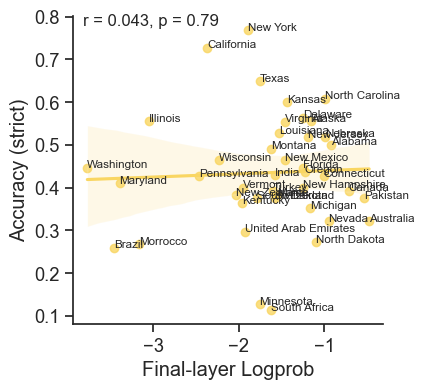

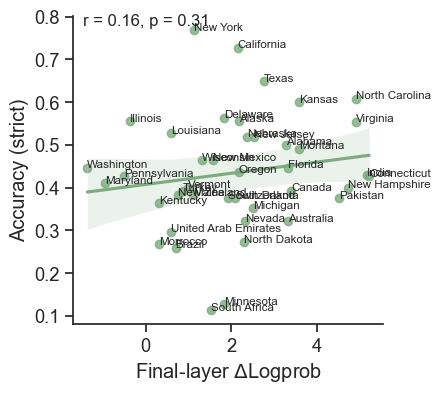

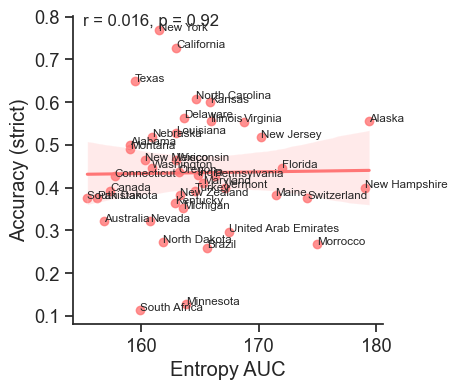

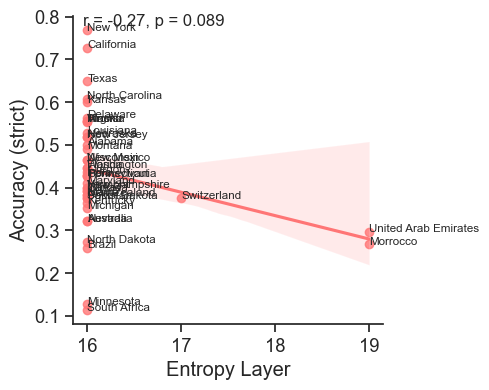

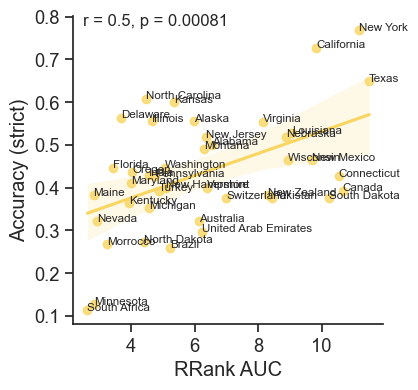

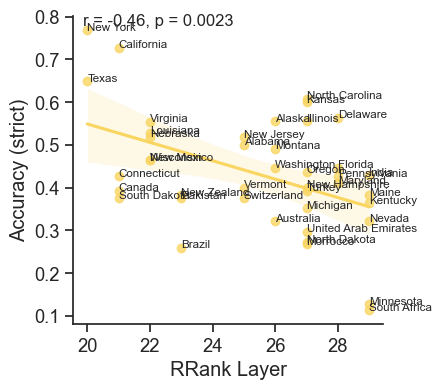

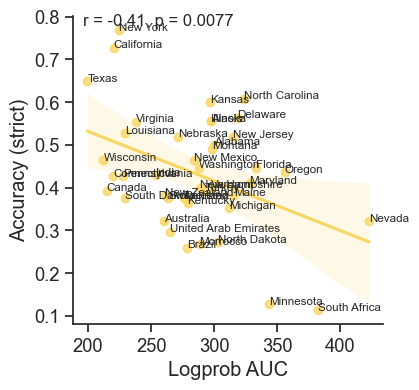

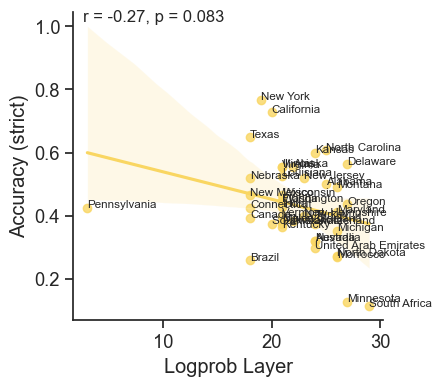

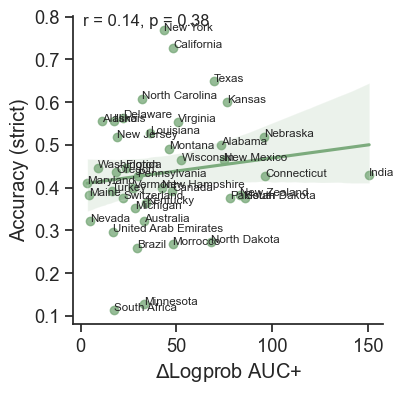

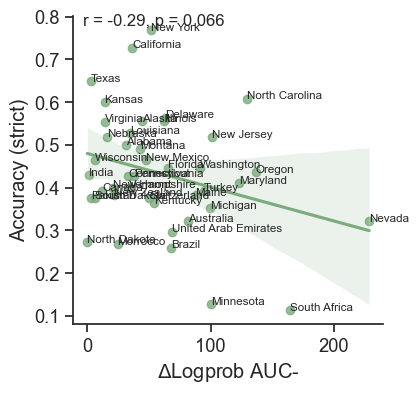

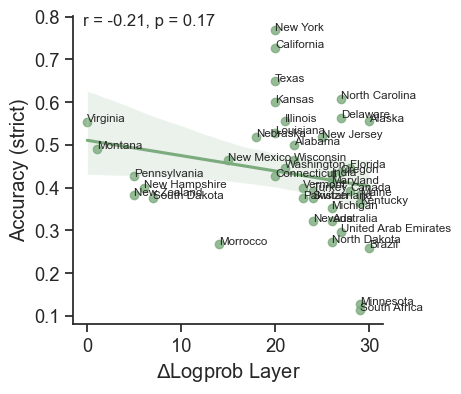

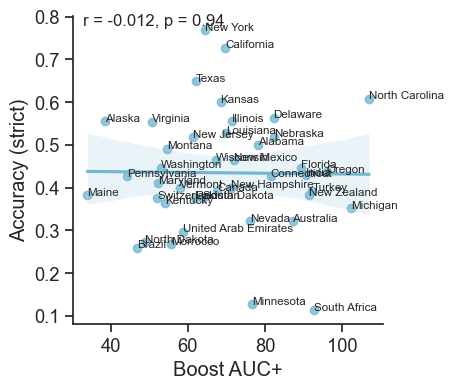

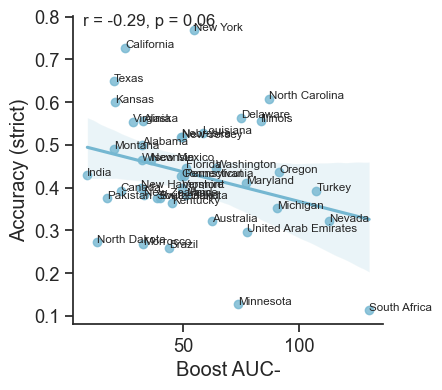

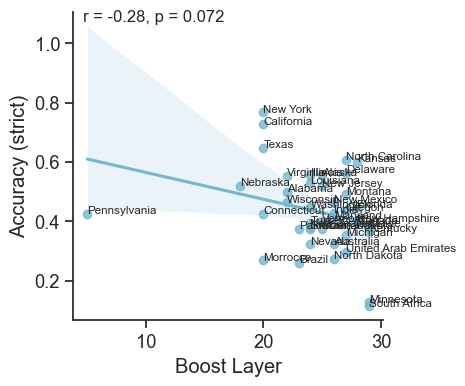

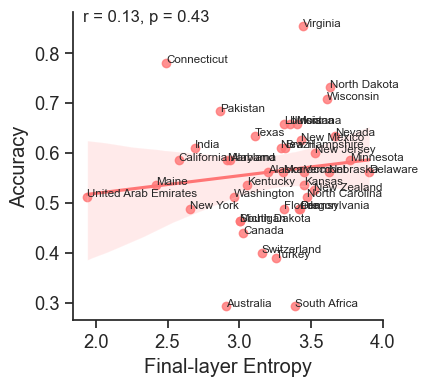

/Users/jenniferhu/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


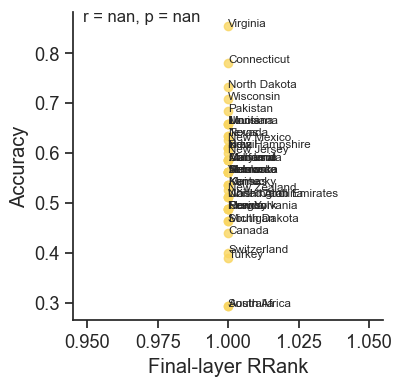

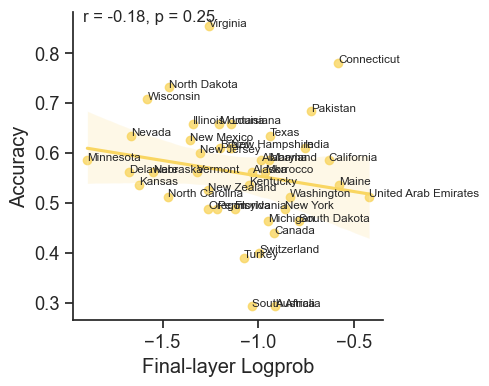

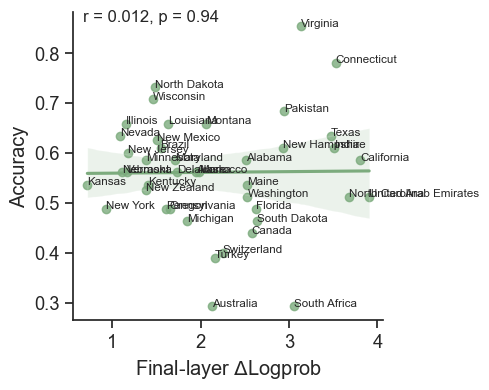

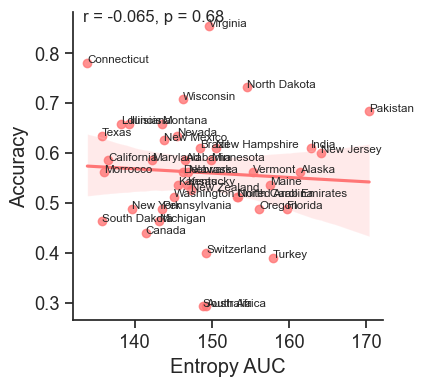

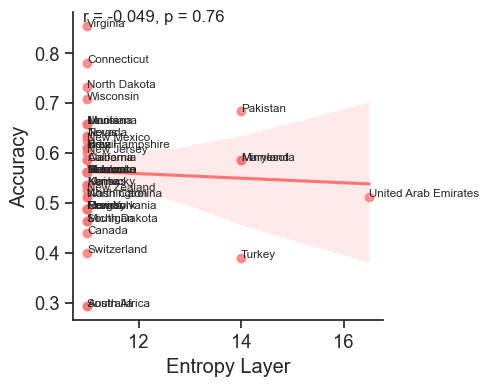

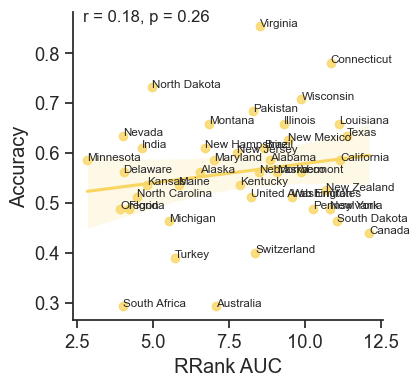

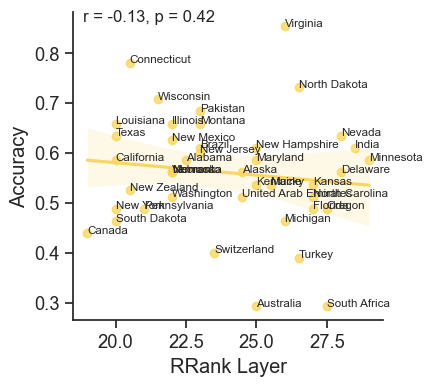

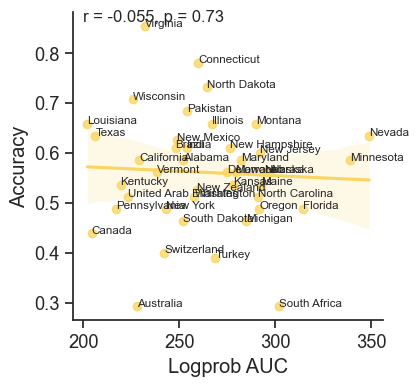

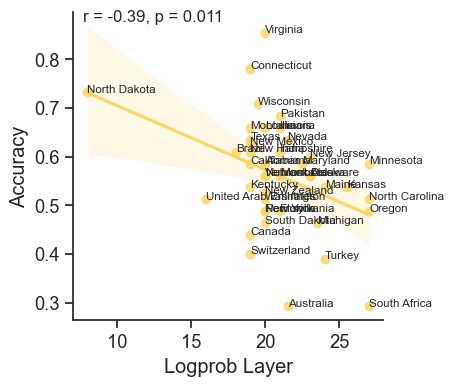

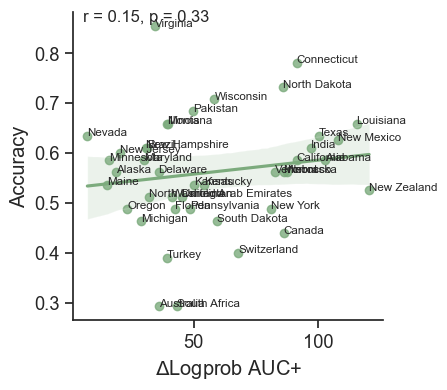

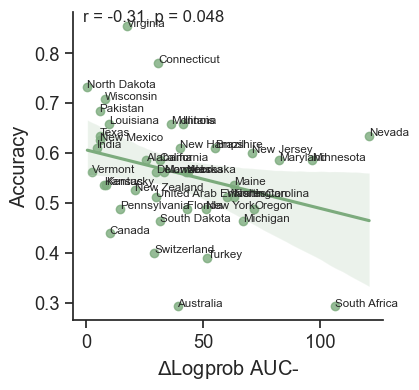

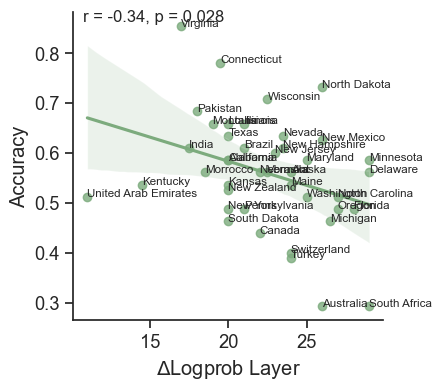

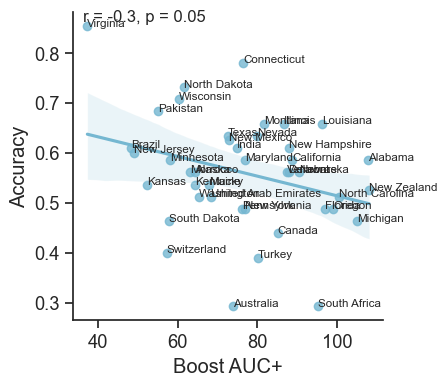

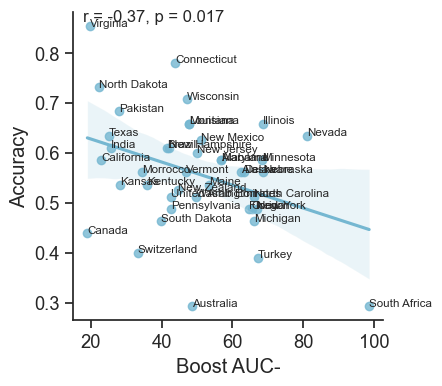

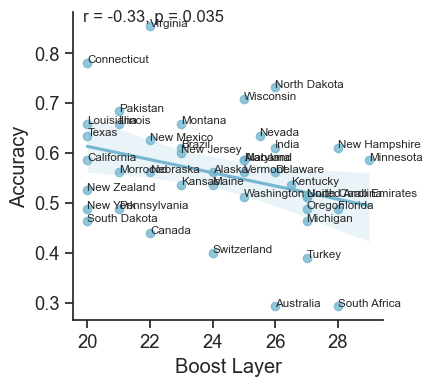

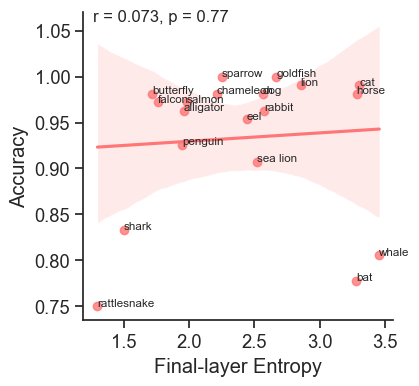

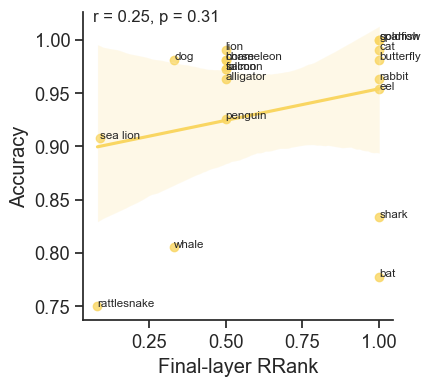

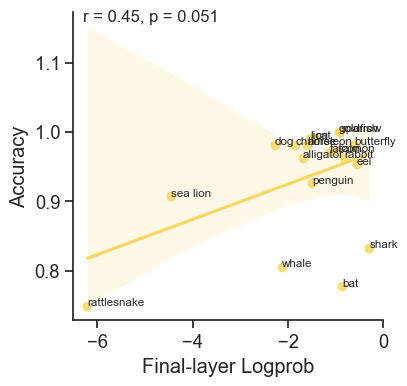

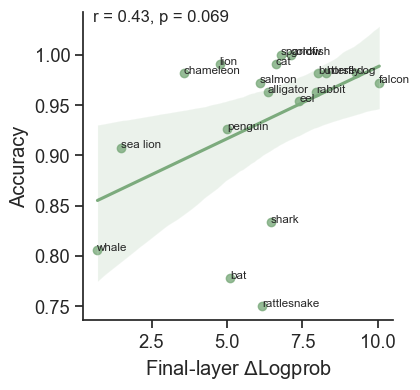

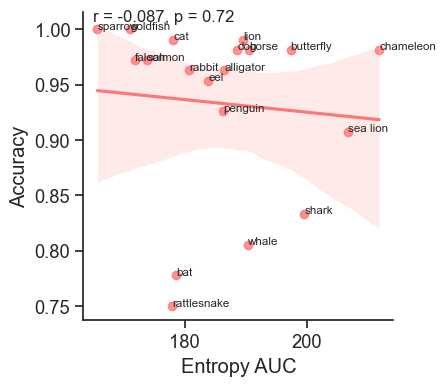

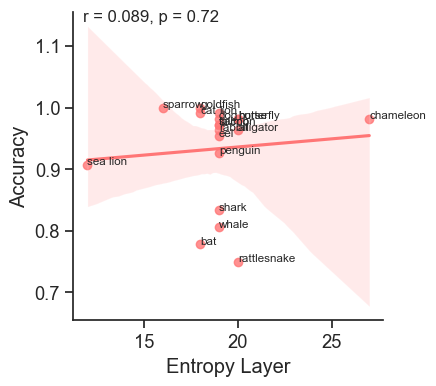

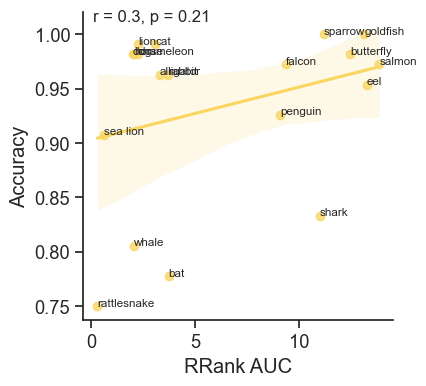

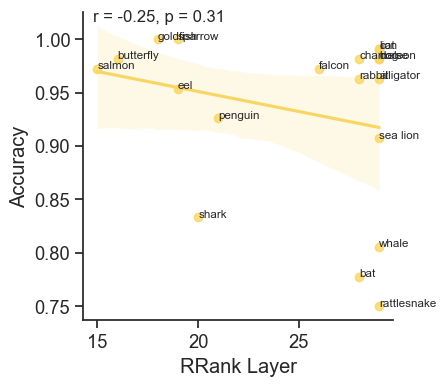

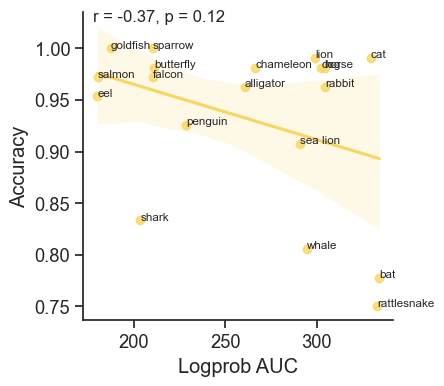

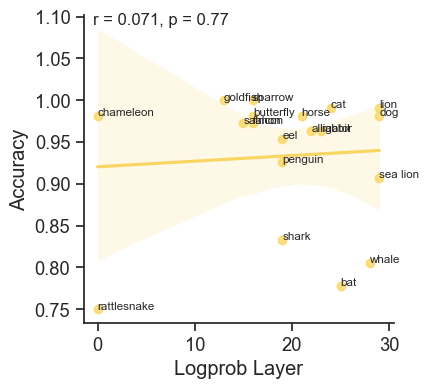

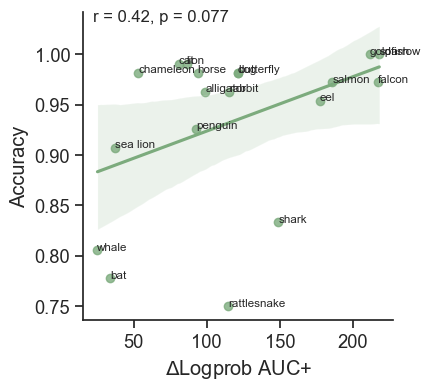

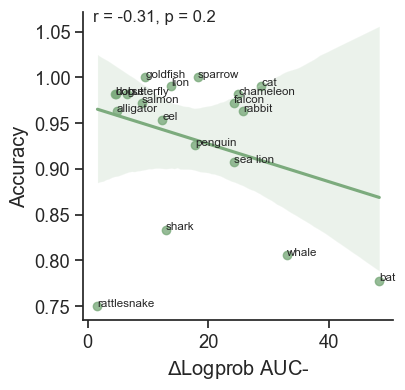

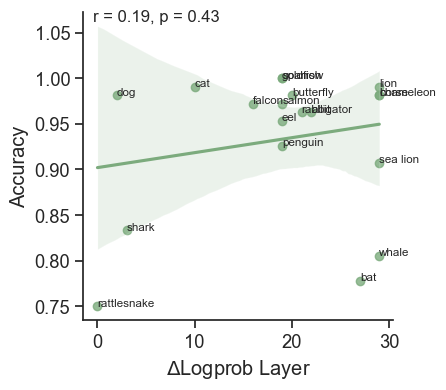

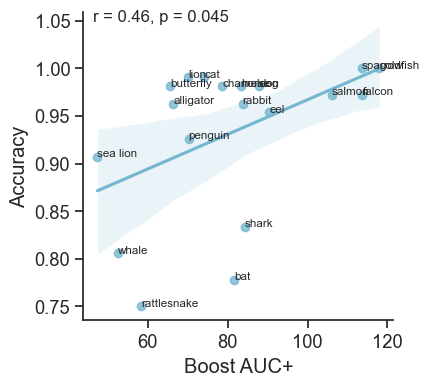

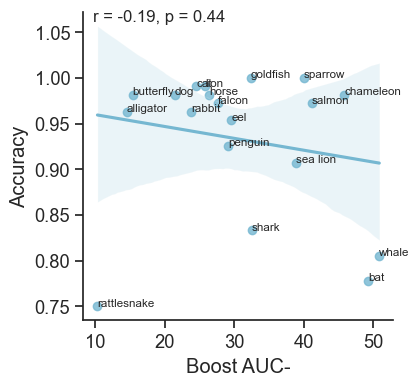

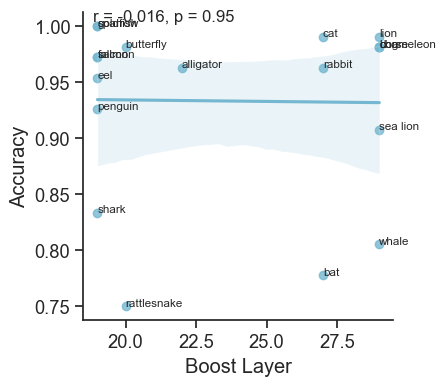

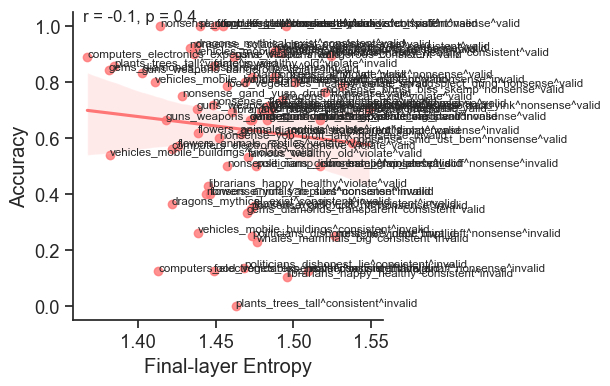

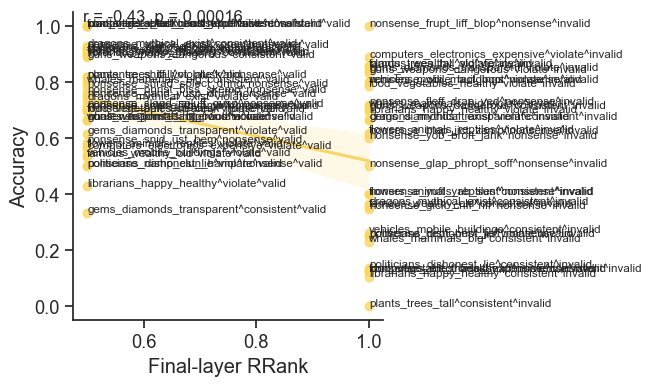

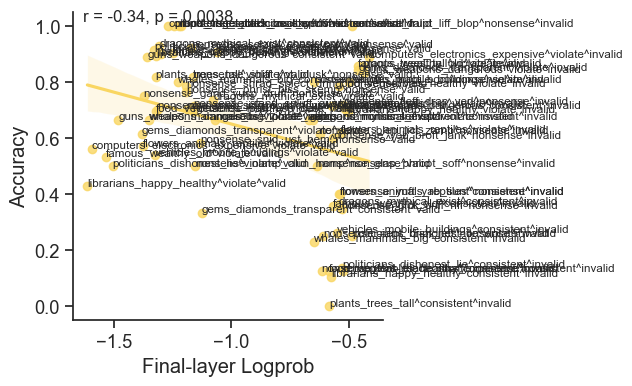

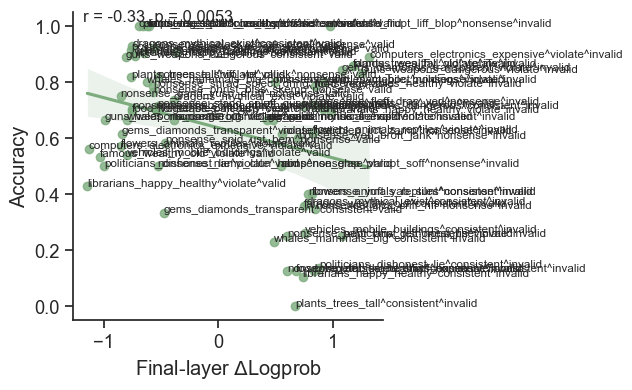

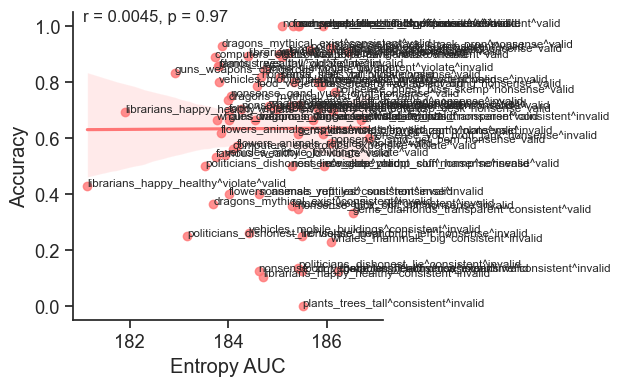

/Users/jenniferhu/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


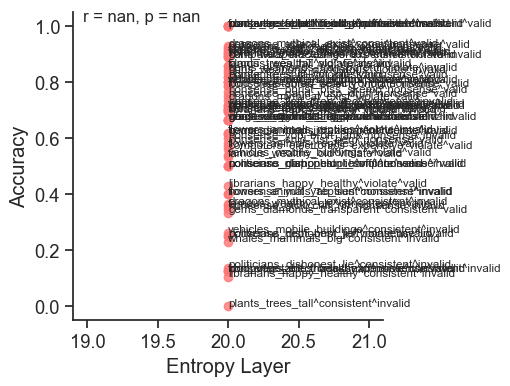

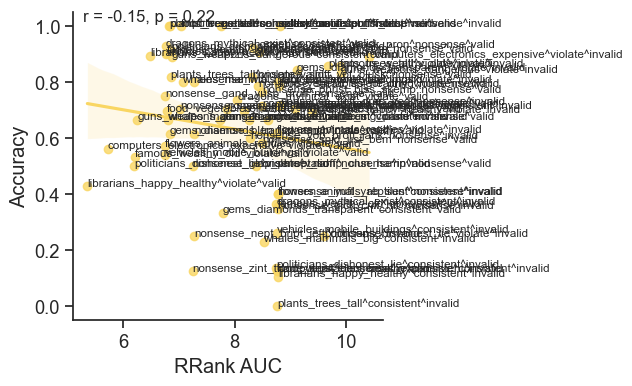

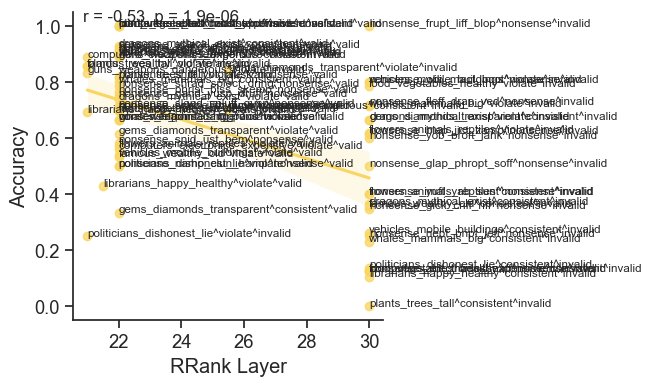

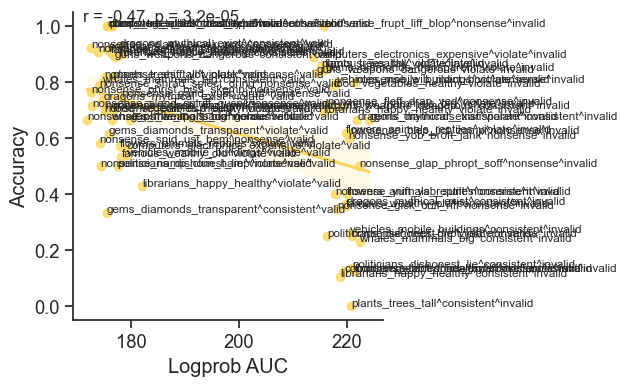

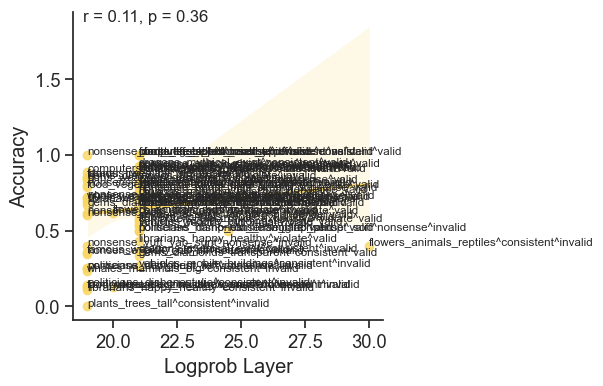

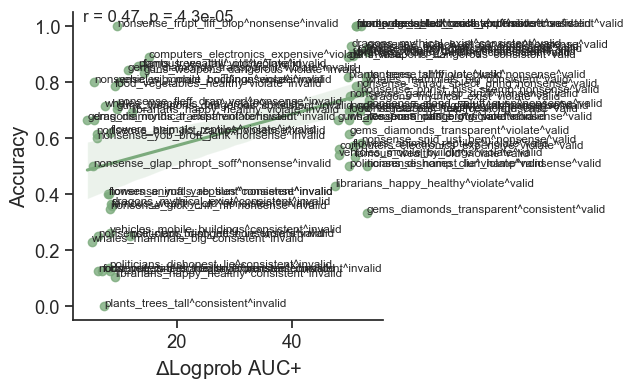

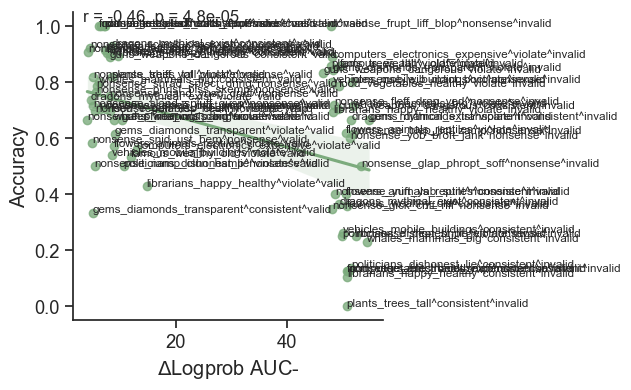

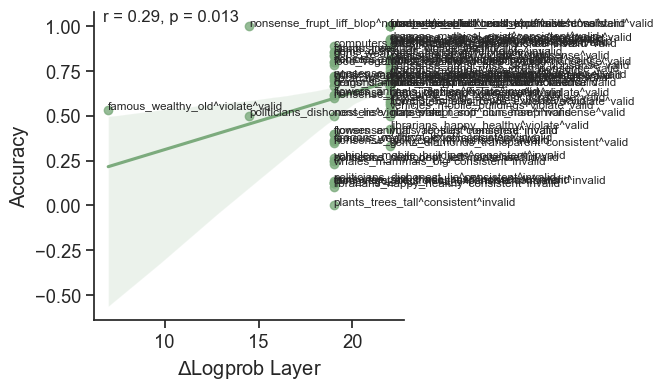

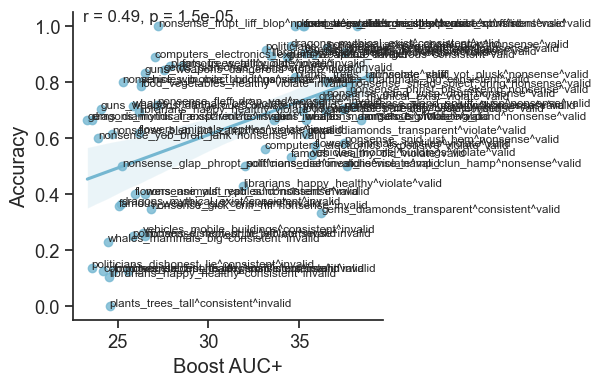

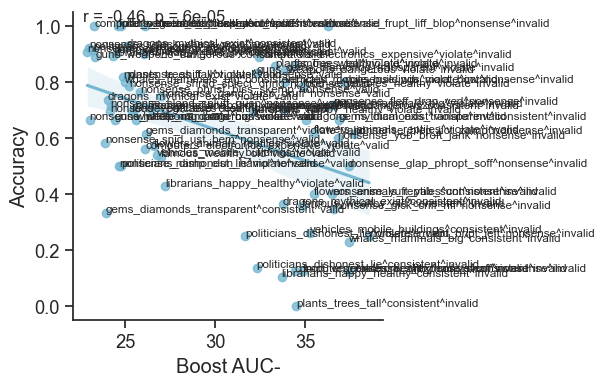

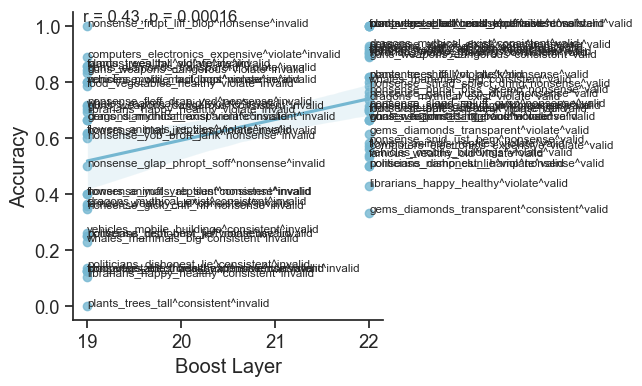

<Figure size 640x480 with 0 Axes>

In [6]:
groupings = {
    "capitals-recall": ["entity"],
    "capitals-recognition": ["entity"],
    "animals": ["exemplar"],
    "syllogism": ["unique_id"]
}
for task in ["capitals-recall", "capitals-recognition", "animals", "syllogism"]:
    df = read_data(task, model="Llama-2-7b-hf")
    if task == "capitals-recall":
        dv = "response_correct_strict"
    else:
        dv = "response_correct"
    for iv in OUTPUT_IVS + PROCESS_IVS:
        if not iv.startswith("control"):
            plot_means(df, dv, iv, grouping=groupings[task], annot=True)
            plt.savefig(f"../../figures/item_means/{task}_{dv}_{iv}.pdf", dpi=300, bbox_inches="tight")
            plt.show()
            plt.clf()